# Actor-Critic Lunar Landing in Discret Invornment

This Jupyter notebook documents the implementation and training of an Actor-Critic model, applied to the "Lunar Lander" environment from OpenAI's Gym. The model architecture is defined, trained through reinforcement learning, and finally, its performance is visually demonstrated by creating GIFs of the landing sequences. The notebook is divided into three main sections, each corresponding to a Python script that builds upon the last, illustrating the development and testing of a reinforcement learning policy.

## Model Definition
In this section, we define the ActorCritic class, a neural network model using PyTorch that predicts both actions and their value estimates given environmental states. The model is equipped with methods for performing forward passes, calculating loss based on rewards, and memory clearing for training iterations.

### Code Description:

* ActorCritic class initialization with layers for action and value estimation.
* Forward pass method for determining actions based on the state input.
* Loss calculation using discounted rewards and policy gradients.
* Memory management methods to clear lists of rewards, log-probabilities, and state values.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(8, 128)
        
        self.action_layer = nn.Linear(128, 4)
        self.value_layer = nn.Linear(128, 1)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        action_probs = F.softmax(self.action_layer(state), dim=-1)
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        actor_loss = 0
        critic_loss = 0 
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            action_loss += action_loss
            actor_loss += actor_loss
            critic_loss += value_loss
            loss += (action_loss + value_loss)   
        return loss, action_loss, value_loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]


## Training the Actor-Critic Model
Here, we focus on training the ActorCritic model using data from the Lunar Lander environment. The script sets up the environment, initializes the model, and contains the main training loop. Actions are selected through the policy, and the model is updated based on the calculated gradients from the loss function.

### Code Description:

* Environment setup and policy initialization.
* Training loop for running episodes, collecting rewards, and updating the model.
* Conditional logic for rendering the environment and saving model checkpoints based on performance criteria.

### Pseudocode for Training Loop

1. **Initialization**
   - Prepare lists for `rewards`, `actor_losses`, `critic_losses`, `trajectory_lengths`.
   - Set training parameters: `gamma`, `lr`, `betas`.
   - Initialize environment (`LunarLander-v2`) and `ActorCritic` policy with `Adam` optimizer.

2. **Start Episodes (up to 10,000)**
   - Reset environment and initialize variables for each episode.
   - **Time Step Loop (up to 10,000 per episode)**
     - Choose action, take step, record rewards, update running reward.
     - Render environment conditionally after 1000 episodes.
     - Break if episode ends (`done` flag is True).

3. **Policy Update Post Episode**
   - Calculate loss, perform backpropagation, and update policy parameters.
   - Clear policy memory.

4. **Logging and Model Saving**
   - Every 20 episodes, log episode number, length, and average reward.
   - Save model if running reward exceeds 4000 and output "solved" message.


In [7]:
import torch
import torch.optim as optim
import gym


rewards,actor_losses,critic_losses,trajectory_lengths =[], [], [], []

def train():
    # Defaults parameters:
    #    gamma = 0.99
    #    lr = 0.02
    #    betas = (0.9, 0.999)
    #    random_seed = 543

    render = False
    gamma = 0.99
    lr = 0.02
    betas = (0.9, 0.999)
    
    
    env = gym.make('LunarLander-v2', render_mode="rgb_array")
    
    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
    print(lr,betas)
    
    running_reward = 0
    for i_episode in range(0, 10000):
        state = env.reset()
        t = -1
        for _ in range(10000):
            t+=1
            action = policy(state)
            info = env.step(action)
            state, reward, done = info[0], info[1], info[2]
            rewards.append(reward)
            policy.rewards.append(reward)
            running_reward += reward
            if render and i_episode > 1000:
                env.render()
            if done:
                break
                    
        # Updating the policy :
        optimizer.zero_grad()
        loss, actor_loss, critic_loss = policy.calculateLoss(gamma)
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)
        loss.backward()
        optimizer.step()        
        policy.clearMemory()
        
        # saving the model if episodes > 999 OR avg reward > 200 
        #if i_episode > 999:
        #    torch.save(policy.state_dict(), './preTrained/LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
        
        if running_reward > 4000:
            torch.save(policy.state_dict(), './preTrained/LunarLander3_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
            print("########## Solved! ##########")
            #test(name='LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
            break
        
        if i_episode % 20 == 0:
            running_reward = running_reward/20
            print('Episode {}\tlength: {}\treward: {}'.format(i_episode, t, running_reward))
            running_reward = 0
        trajectory_lengths.append(t)
            
if __name__ == '__main__':
    train()


0.02 (0.9, 0.999)


/tmp/ipykernel_4726/3195387581.py:52: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode 0	length: 104	reward: -5.867779452909385
Episode 20	length: 240	reward: -842.1961744775426
Episode 40	length: 127	reward: -821.0566829834721
Episode 60	length: 79	reward: -810.2262518600481
Episode 80	length: 96	reward: -773.8379960385811
Episode 100	length: 89	reward: -586.0083098614122
Episode 120	length: 158	reward: -323.8877117747522
Episode 140	length: 102	reward: -162.19531205073176
Episode 160	length: 152	reward: -148.60423575718926
Episode 180	length: 84	reward: -152.75925986106688
Episode 200	length: 152	reward: -177.2437335598224
Episode 220	length: 97	reward: -126.43593282816717
Episode 240	length: 91	reward: -207.27080519567335
Episode 260	length: 371	reward: -319.46228404242135
Episode 280	length: 207	reward: -448.4610980426066
Episode 300	length: 104	reward: -89.67156774223797
Episode 320	length: 113	reward: -23.045796162629518
Episode 340	length: 130	reward: -315.2050417689487
Episode 360	length: 326	reward: -380.6291576705346
Episode 380	length: 337	reward: -254

In [37]:
rewards2 = [ (a+b).item() for a,b in zip(actor_losses[:-1], critic_losses[:-1])]
actor_losses2 = [a.item() for a in actor_losses[:-1]]
critic_losses2 = [a.item() for a in critic_losses[:-1]]

In [39]:
import pandas as pd

all_results = {
    "rewards": rewards2,
    "actor_losses": actor_losses2,
    "critic_losses": critic_losses2,
    "trajectory_lengths": trajectory_lengths
}

df = pd.DataFrame(all_results)
df.to_csv('results.csv')

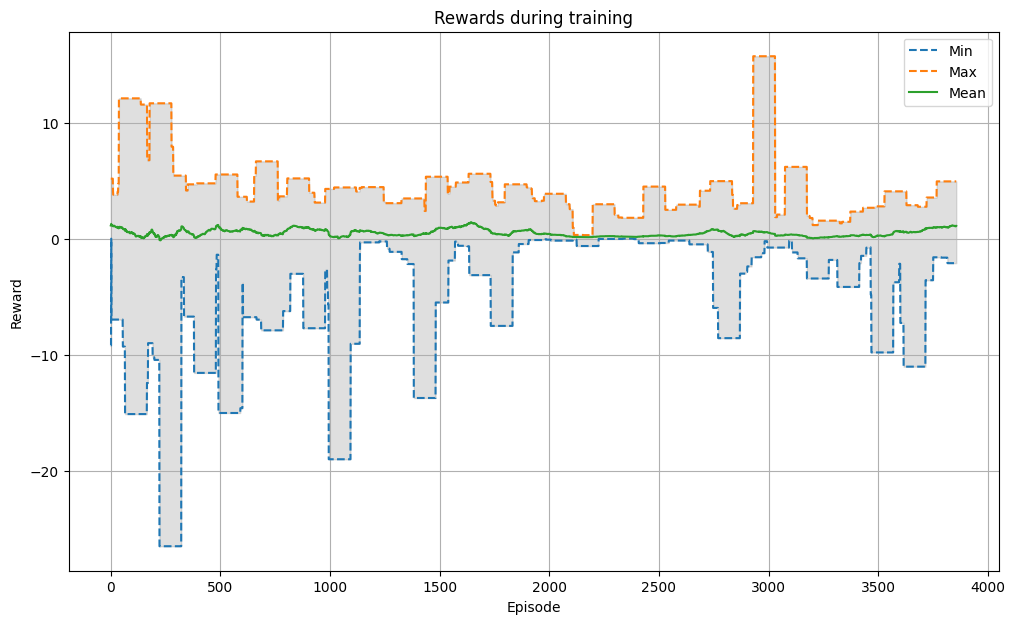

In [45]:
import matplotlib.pyplot as plt
import numpy as np

interval = 100
min_r = [min(rewards2[i:i+interval]) for i in range(len(rewards2)-interval)]
max_r = [max(rewards2[i:i+interval]) for i in range(len(rewards2)-interval)]
plt.figure(figsize=(12, 7))
plt.plot(min_r, label="Min", linestyle='--')
plt.plot(max_r, label="Max", linestyle='--')
plt.plot([np.mean(rewards2[i:i+interval]) for i in range(len(rewards2)-interval)], label="Mean")
plt.legend()
plt.fill_between(range(len(rewards2)-interval), min_r, max_r, color='gray', alpha=0.25)
plt.title("Rewards during training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig('aggregated_rewards.png')


## Testing and Visualization
The final part of the notebook involves loading a trained model to evaluate its performance and visualizing the results through GIFs. The script tests the model in the environment, captures frames, and creates a GIF to showcase the landing sequence.

### Code Description:

* Loading the trained model and setting up the testing environment.
* Running evaluation episodes, rendering frames, and saving them as images.
* Using the saved images to create a GIF demonstrating the agent's performance.

In [49]:
from model import ActorCritic
import torch
import gym
import numpy as np 
from PIL import Image
import os
import imageio

# Example usage:
# create_gif('/path/to/image_folder', '/path/to/output/output.gif', 0.5)

def test(n_episodes=1, name='LunarLander_TWO.pth'):
    env = gym.make('LunarLander-v2', render_mode="rgb_array")
    policy = ActorCritic()
    
    policy.load_state_dict(torch.load('./preTrained/{}'.format(name)))
    
    render = True
    save_gif = True

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        running_reward = 0
        for t in range(10000):
            action = policy(state)
            info = env.step(action)
            state, reward, done = info[0], info[1], info[2]
            running_reward += reward
            if render:
                 if save_gif:
                    img = env.render()
                    img = np.array(img)
                    img = img[0]
                    img = Image.fromarray(img)
                    os.makedirs(f'./solutions/attepmt3', exist_ok=True) 
                    img.save(f'./solutions/attepmt3/{t}.jpg')
            if done:
                break
        print('Episode {}\tReward: {}'.format(i_episode, running_reward))
    env.close()
            
if __name__ == '__main__':
    test(name="LunarLander3_0.02_0.9_0.999.pth")

Episode 1	Reward: 232.3009153783145


In [ ]:
! pip uninstall Pillow -y
! pip install Pillow


Found existing installation: Pillow 9.0.1
Uninstalling Pillow-9.0.1:
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/lib/python3.10/shutil.py", line 816, in move
    os.rename(src, real_dst)
PermissionError: [Errno 13] Permission denied: '/usr/lib/python3/dist-packages/PIL' -> '/tmp/pip-uninstall-umx9tu82'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kamil/.local/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "/home/kamil/.local/lib/python3.10/site-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/home/kamil/.local/lib/python3.10/site-packages/pip/_internal/req/req_install.py", line 727, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/home/kamil/.local/lib/python3.10/site-packages/pip/_internal/req/req_uninstall.py", line

In [55]:
import os
import re
from PIL import Image

def numerical_sort(value):
    # This regular expression extracts all numbers in the file path and joins them into one number, assuming the structure is consistent
    parts = re.compile(r'\d+').findall(value)
    return int(parts[-1])  # Converts the last numeric part to an integer for sorting


def create_gif_with_pillow(image_folder, output_path, duration=500):
    """
    Create a GIF from a sequence of images in a folder using Pillow.

    Parameters:
    - image_folder: str, the path to the folder containing images.
    - output_path: str, the path where the GIF should be saved.
    - duration: int, the duration each image is displayed in the GIF in milliseconds.
    """
    # List all files in the directory and sort them
    files = [os.path.join(image_folder, file) for file in sorted(os.listdir(image_folder)) if file.endswith(('.png', '.jpg', '.jpeg'))]
    files = sorted(files, key=numerical_sort)
    # Load all the images
    
    images = [Image.open(image) for image in files if os.path.isfile(image)]
    
    # Convert images to the same mode for compatibility
    images = [image.convert('RGBA') for image in images]
    
    # Specify the output path for the GIF
    gif_path = os.path.join(output_path, "output.gif")

    # Save the images as a GIF
    images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

    print(f"GIF created at {gif_path}")

# Usage example:
create_gif_with_pillow("./solutions/attepmt3", "./solutions", duration=25)  # Duration in milliseconds


GIF created at ./solutions/output.gif


## Summary
This notebook provides a comprehensive look at setting up, training, and evaluating a reinforcement learning model for the Lunar Lander task. Starting from the model's architectural definition, through training with reinforcement learning techniques, to visualizing the outcomes, each step is detailed for clarity and reproducibility. This serves as a practical introduction to applying deep learning techniques in reinforcement learning environments.

